# Analysis of research
## A presentation on different approaches to clustering NFTRank data

This notebook will cover various topics including clustering algorithms and dimension reduction techniques via Python. The goal of this research is to mix different approaches of dimension reduction techniques with clustering algorithms (PCA with K-Means, or UMAP with DBSCAN) to prove that clustering NFTRank data is possible for SwapEase. Finding/creating a successful approach will give SwapEase a critical edge in the market. Such a process does not exist in the NFT space, and can be a powerful tool in a seasoned trader's hands. The summation of this research will help create descriptive enough data that will provide key insights for NFT arbitrage. 

I believe that clustering NFTs within a specific collection can help us achieve this. We can extract key information from "like NFTs" with efficient performance at scale. Information included could be anything from averages of trades to performance of clusters in the current market. This would be guided by the cluster since it reduces the scope of information to conglomerate.

In [1]:
import pandas
from sklearn.preprocessing import StandardScaler

# The data file path used in this document
KOIN_path = "./data/KOIN.csv"
BAYC_path = "./data/BAYC.csv"
DOODLES_path = "./data/DOODLES.csv"
MEKA_path = "./data/MEKA.csv"

constants = [
    {
        'path': KOIN_path,
        'name': "KOIN"
    },
    {
        'path': BAYC_path,
        'name': "BAYC"
    },
    {
        'path': DOODLES_path,
        'name': "DOODLES"
    },
    {
        'path': MEKA_path,
        'name': "MEKA"
    },
]

# Function to retrieve and set data in a data frame
def retrieve_data_from_csv(path):
    df = pandas.read_csv(path, index_col='token_id')
    return df

# Retrieve all data from constants
def retrieve_data():
    data_frames = []

    for constant in constants:
        data_frames.append(retrieve_data_from_csv(constant['path']))

    return data_frames

# Scale data using StandardScaler
def scale_data():
    scaled_data_frames = []

    for df in NFT_dfs:
        scaled_data_frames.append(StandardScaler().fit_transform(df))

    return scaled_data_frames

NFT_dfs = retrieve_data()
scaled_dfs = scale_data()

In [11]:
# Some functions necessary to analyze the clusters

# Creates an object containing information about the cluster
def get_clusters_dict(labels, data_frame):
    clusters_dict = {}

    for index, token_id in enumerate(data_frame.index):
        # Grab tha lable from the clusters array
        label = labels[index]
        token_information = {
            "token_id": token_id, 
            "rank": index + 1, 
            "token_information": data_frame.iloc[index].values
        }

        # Check if label is in dictionary
        if label in clusters_dict.keys():
            clusters_dict[label].append(token_information)
        else:
            clusters_dict[label] = [token_information]

    return clusters_dict

# Generates Avgs based on Rank and Score, as well as top five ranked NFTs for a cluster
def analyze_clusters(clusters_dict):
    analysis = []
    rank_avg = []
    rank_sum_avg = []
    cluster_keys = clusters_dict.keys()

    for cluster_num in cluster_keys:
        rank_sum = 0
        rank_score_sum = 0
        token_ids = []
        ranks = []

        # Generate rank_sum, rank_score_sum, and gather token_ids
        for token in clusters_dict[cluster_num]:
            rank_sum += token['rank']
            rank_score_sum += sum(token['token_information'])
            token_ids.append(token['token_id'])
            ranks.append(token['rank'])
        
        top_five = sorted(zip(ranks, token_ids), key=lambda t: t[0])[:5]

        # Add top_five tokens in a cluster and cluster number to analysis array
        analysis.append({
            "cluster_#": cluster_num + 1,
            "top_five": top_five
        })
        rank_avg.append(rank_sum/len(clusters_dict[cluster_num]))
        rank_sum_avg.append(rank_score_sum/len(clusters_dict[cluster_num]))

    # Load avgs into pandas df
    avg_df = pandas.DataFrame({"Rank Avg": rank_avg, "Rank Sum Avg": rank_sum_avg}, columns = ['Rank Avg', 'Rank Sum Avg'])

    return {"analysis": analysis, "avg_df": avg_df}

# Creates analysis for all data sets
def get_analysis(clusters):
    cluster_dicts = []

    for i in range(len(NFT_dfs)):
        cluster_dicts.append(get_clusters_dict(clusters[i], NFT_dfs[i]))
    
    analysis = []

    for cluster_dict in cluster_dicts:
        analysis.append(analyze_clusters(cluster_dict))

    return analysis

### PCA Analysis

In [3]:
from sklearn.decomposition import PCA
import numpy as np

def create_embeddings():
    embeddings = []
    reducers = []

    for index, scaled_df in enumerate(scaled_dfs):
        reducer = PCA(n_components=2, random_state=42)
        embeddings.append(reducer.fit_transform(scaled_df))
        print('{}: '.format(constants[index]['name']))
        print('Explained variation per principal component: {}'.format(reducer.explained_variance_ratio_))
        print('Cumulative variance explained by 2 principal components: {:.2%}\n'.format(
            np.sum(reducer.explained_variance_ratio_)))

    return embeddings

PCA_embeddings = create_embeddings()

KOIN: 
Explained variation per principal component: [0.76261175 0.1138104 ]
Cumulative variance explained by 2 principal components: 87.64%

BAYC: 
Explained variation per principal component: [0.16037164 0.13302916]
Cumulative variance explained by 2 principal components: 29.34%

DOODLES: 
Explained variation per principal component: [0.49488739 0.14611529]
Cumulative variance explained by 2 principal components: 64.10%

MEKA: 
Explained variation per principal component: [0.42416295 0.08459327]
Cumulative variance explained by 2 principal components: 50.88%



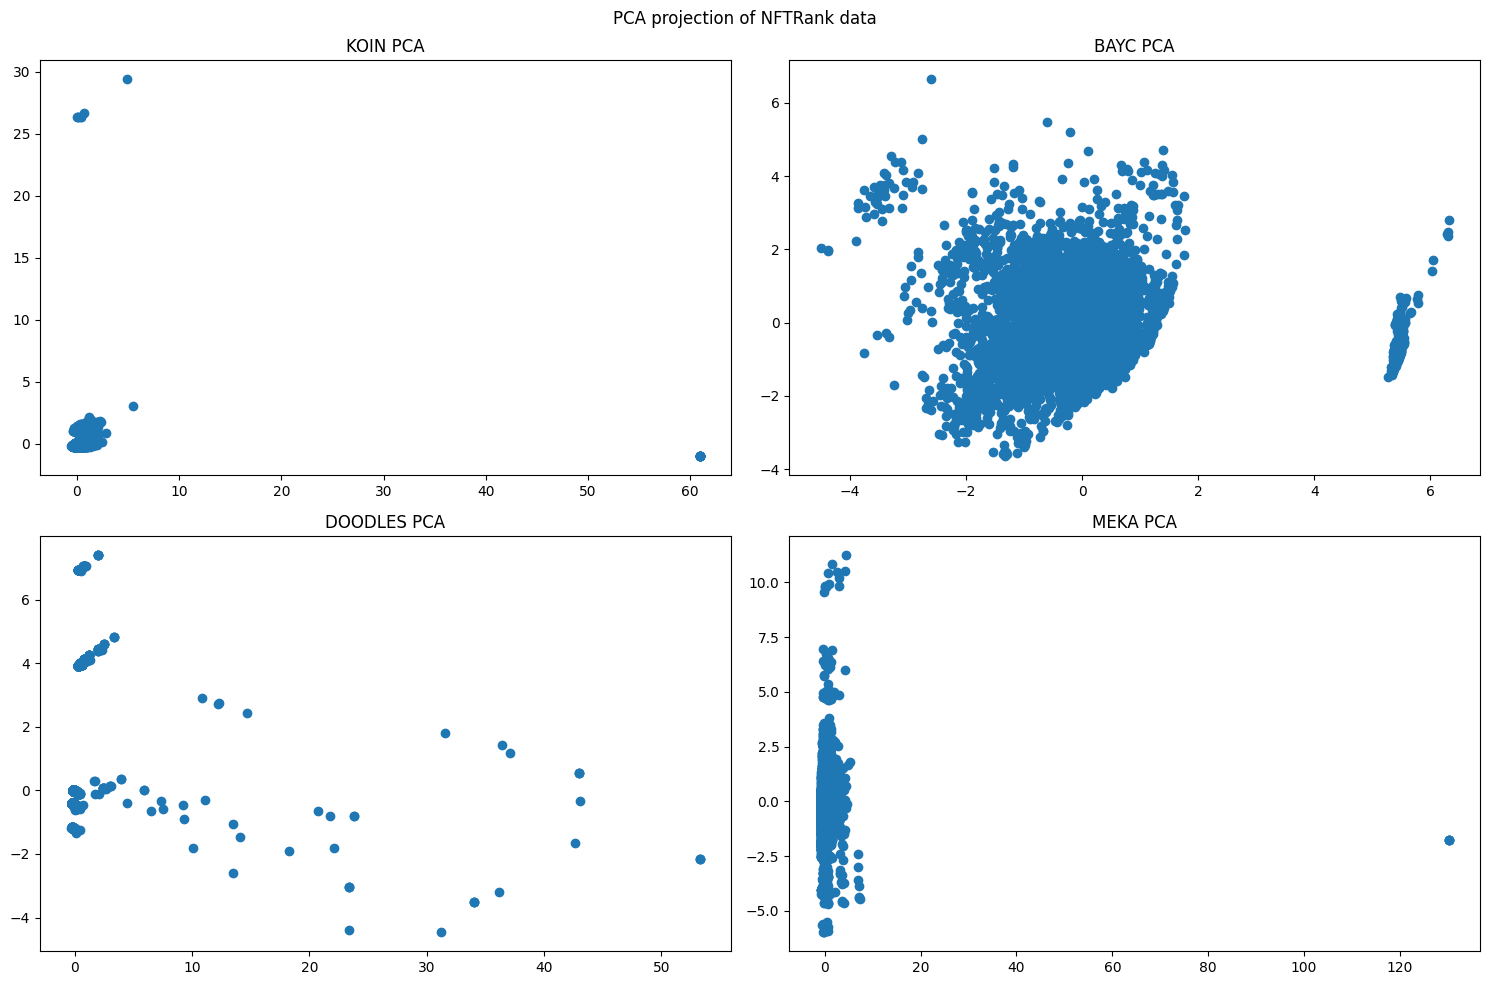

In [4]:
import matplotlib.pyplot as plt

def generate_PCA_plots(embeddings):
    fig, axs = plt.subplots(2,2, figsize=(15,10))
    
    fig.suptitle("PCA projection of NFTRank data")

    axs[0,0].set_title("{} PCA".format(constants[0]['name']))
    axs[0,0].scatter(embeddings[0][:, 0], embeddings[0][:, 1])

    axs[0,1].set_title("{} PCA".format(constants[1]['name']))
    axs[0,1].scatter(embeddings[1][:, 0], embeddings[1][:, 1])

    axs[1,0].set_title("{} PCA".format(constants[2]['name']))
    axs[1,0].scatter(embeddings[2][:, 0], embeddings[2][:, 1])

    axs[1,1].set_title("{} PCA".format(constants[3]['name']))
    axs[1,1].scatter(embeddings[3][:, 0], embeddings[3][:, 1])

    fig.tight_layout()
    plt.show()

generate_PCA_plots(PCA_embeddings)

In [5]:
# Displays clustered data from UMAP via clustering methods AND displays analysis plots to see where clusters scale
def generate_PCA_cluster_plots_and_analyze(embeddings, clusters, analysis, cluster_method_title):
    fig, axs = plt.subplots(4,2, figsize=(15,20))
    
    fig.suptitle("PCA projection of NFTRank data {}".format(cluster_method_title))

    axs[0,0].set_title("{} Clusters".format(constants[0]['name']))
    axs[0,0].scatter(embeddings[0][:, 0], embeddings[0][:, 1], c=clusters[0])

    axs[0,1].set_title("{} Clusters".format(constants[1]['name']))
    axs[0,1].scatter(embeddings[1][:, 0], embeddings[1][:, 1], c=clusters[1])

    axs[1,0].set_title("{} Clusters".format(constants[2]['name']))
    axs[1,0].scatter(embeddings[2][:, 0], embeddings[2][:, 1], c=clusters[2])

    axs[1,1].set_title("{} Clusters".format(constants[3]['name']))
    axs[1,1].scatter(embeddings[3][:, 0], embeddings[3][:, 1], c=clusters[3])

    axs[2,0].set_title("{} analysis ({} points)".format(constants[0]['name'],len(analysis[0]['avg_df'])))
    axs[2,0].scatter(x=analysis[0]['avg_df']['Rank Avg'], y=analysis[0]['avg_df']['Rank Sum Avg'])

    axs[2,1].set_title("{} analysis ({} points)".format(constants[1]['name'],len(analysis[1]['avg_df'])))
    axs[2,1].scatter(x=analysis[1]['avg_df']['Rank Avg'], y=analysis[1]['avg_df']['Rank Sum Avg'])

    axs[3,0].set_title("{} analysis ({} points)".format(constants[2]['name'],len(analysis[2]['avg_df'])))
    axs[3,0].scatter(x=analysis[2]['avg_df']['Rank Avg'], y=analysis[2]['avg_df']['Rank Sum Avg'])

    axs[3,1].set_title("{} analysis ({} points)".format(constants[3]['name'],len(analysis[3]['avg_df'])))
    axs[3,1].scatter(x=analysis[3]['avg_df']['Rank Avg'], y=analysis[3]['avg_df']['Rank Sum Avg'])
    
    fig.tight_layout()
    plt.show()

### Clustering with DBSCAN

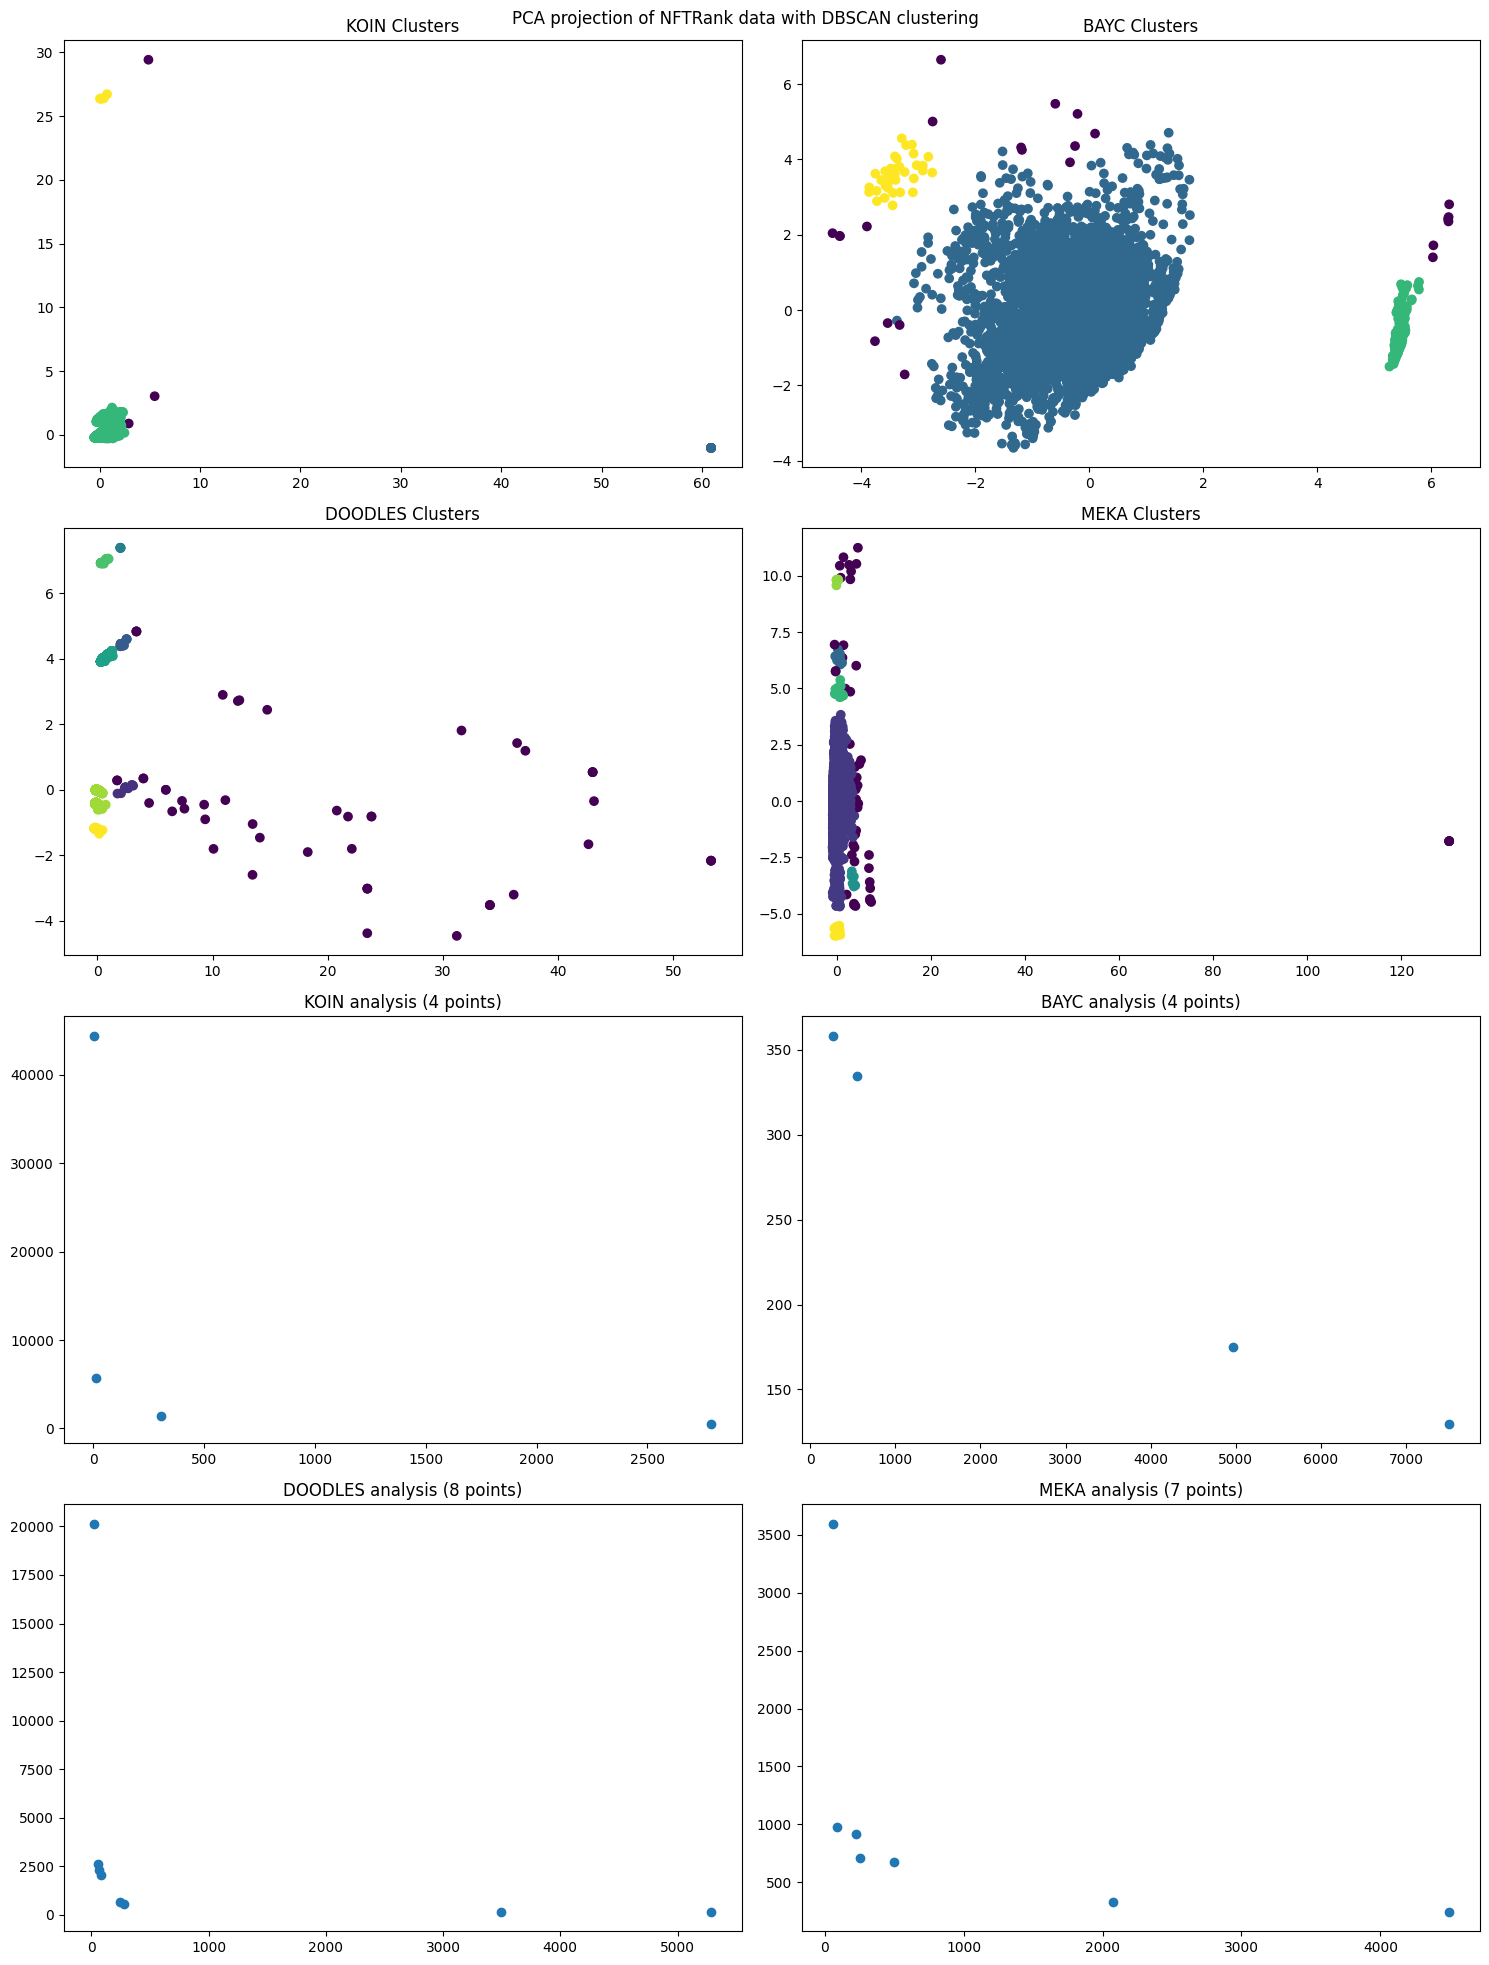

In [6]:
from sklearn.cluster import DBSCAN

def get_DBSCAN_clusters(embeddings):
    clusters = []

    for embedding in embeddings:
        clusterer_DBSCAN = DBSCAN(eps=.5)
        clusters.append(clusterer_DBSCAN.fit_predict(embedding))

    return clusters

PCA_DBSCAN_clusters = get_DBSCAN_clusters(PCA_embeddings)
PCA_DBSCAN_analysis = get_analysis(PCA_DBSCAN_clusters)

generate_PCA_cluster_plots_and_analyze(PCA_embeddings, PCA_DBSCAN_clusters, PCA_DBSCAN_analysis, "with DBSCAN clustering")

### Clustering with KMeans

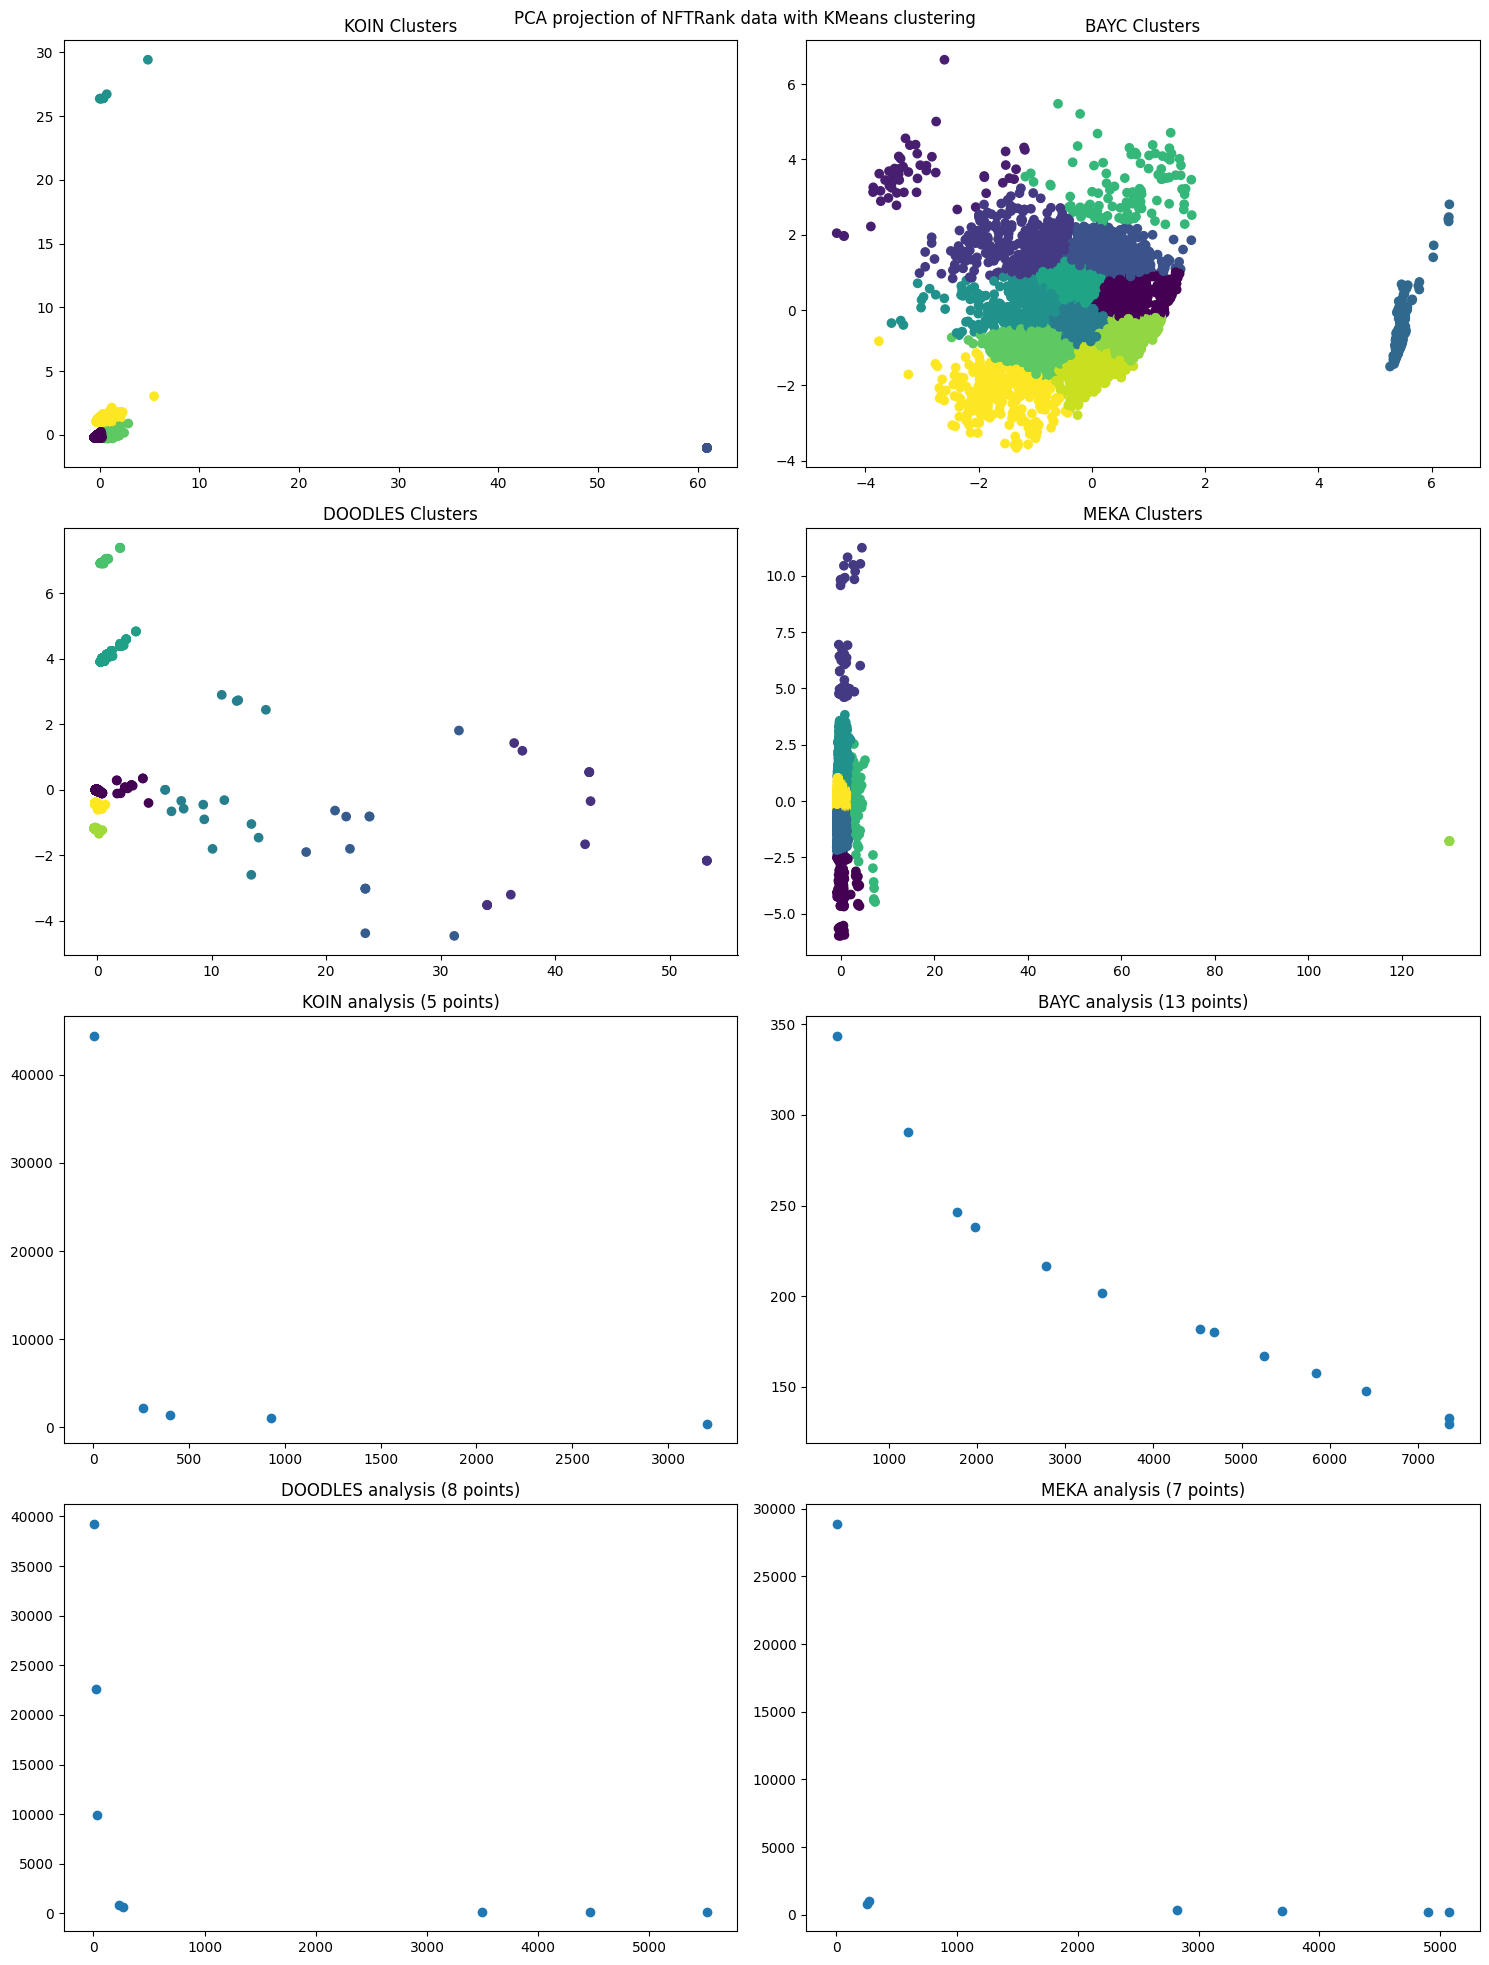

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans_kwargs = {
    "init": "random",
    "n_init": 50,
    "max_iter": 500,
}

def get_KMeans_labels_via_silhouette(embeddings):
    kmeans_labels = []

    for embedding in embeddings:
        best_score = -1
        labels = 0

        for k in range(5, 15):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            kmeans.fit(embedding)
            score = silhouette_score(embedding, kmeans.labels_)

            if score > best_score:
                best_score = score
                labels = kmeans.labels_

        kmeans_labels.append(labels)

    return kmeans_labels

KMean_clusters = get_KMeans_labels_via_silhouette(PCA_embeddings)
UMAP_KMean_analysis = get_analysis(KMean_clusters)

generate_PCA_cluster_plots_and_analyze(PCA_embeddings, KMean_clusters, UMAP_KMean_analysis, "with KMeans clustering")

### Clustering with Agglormerative Clustering

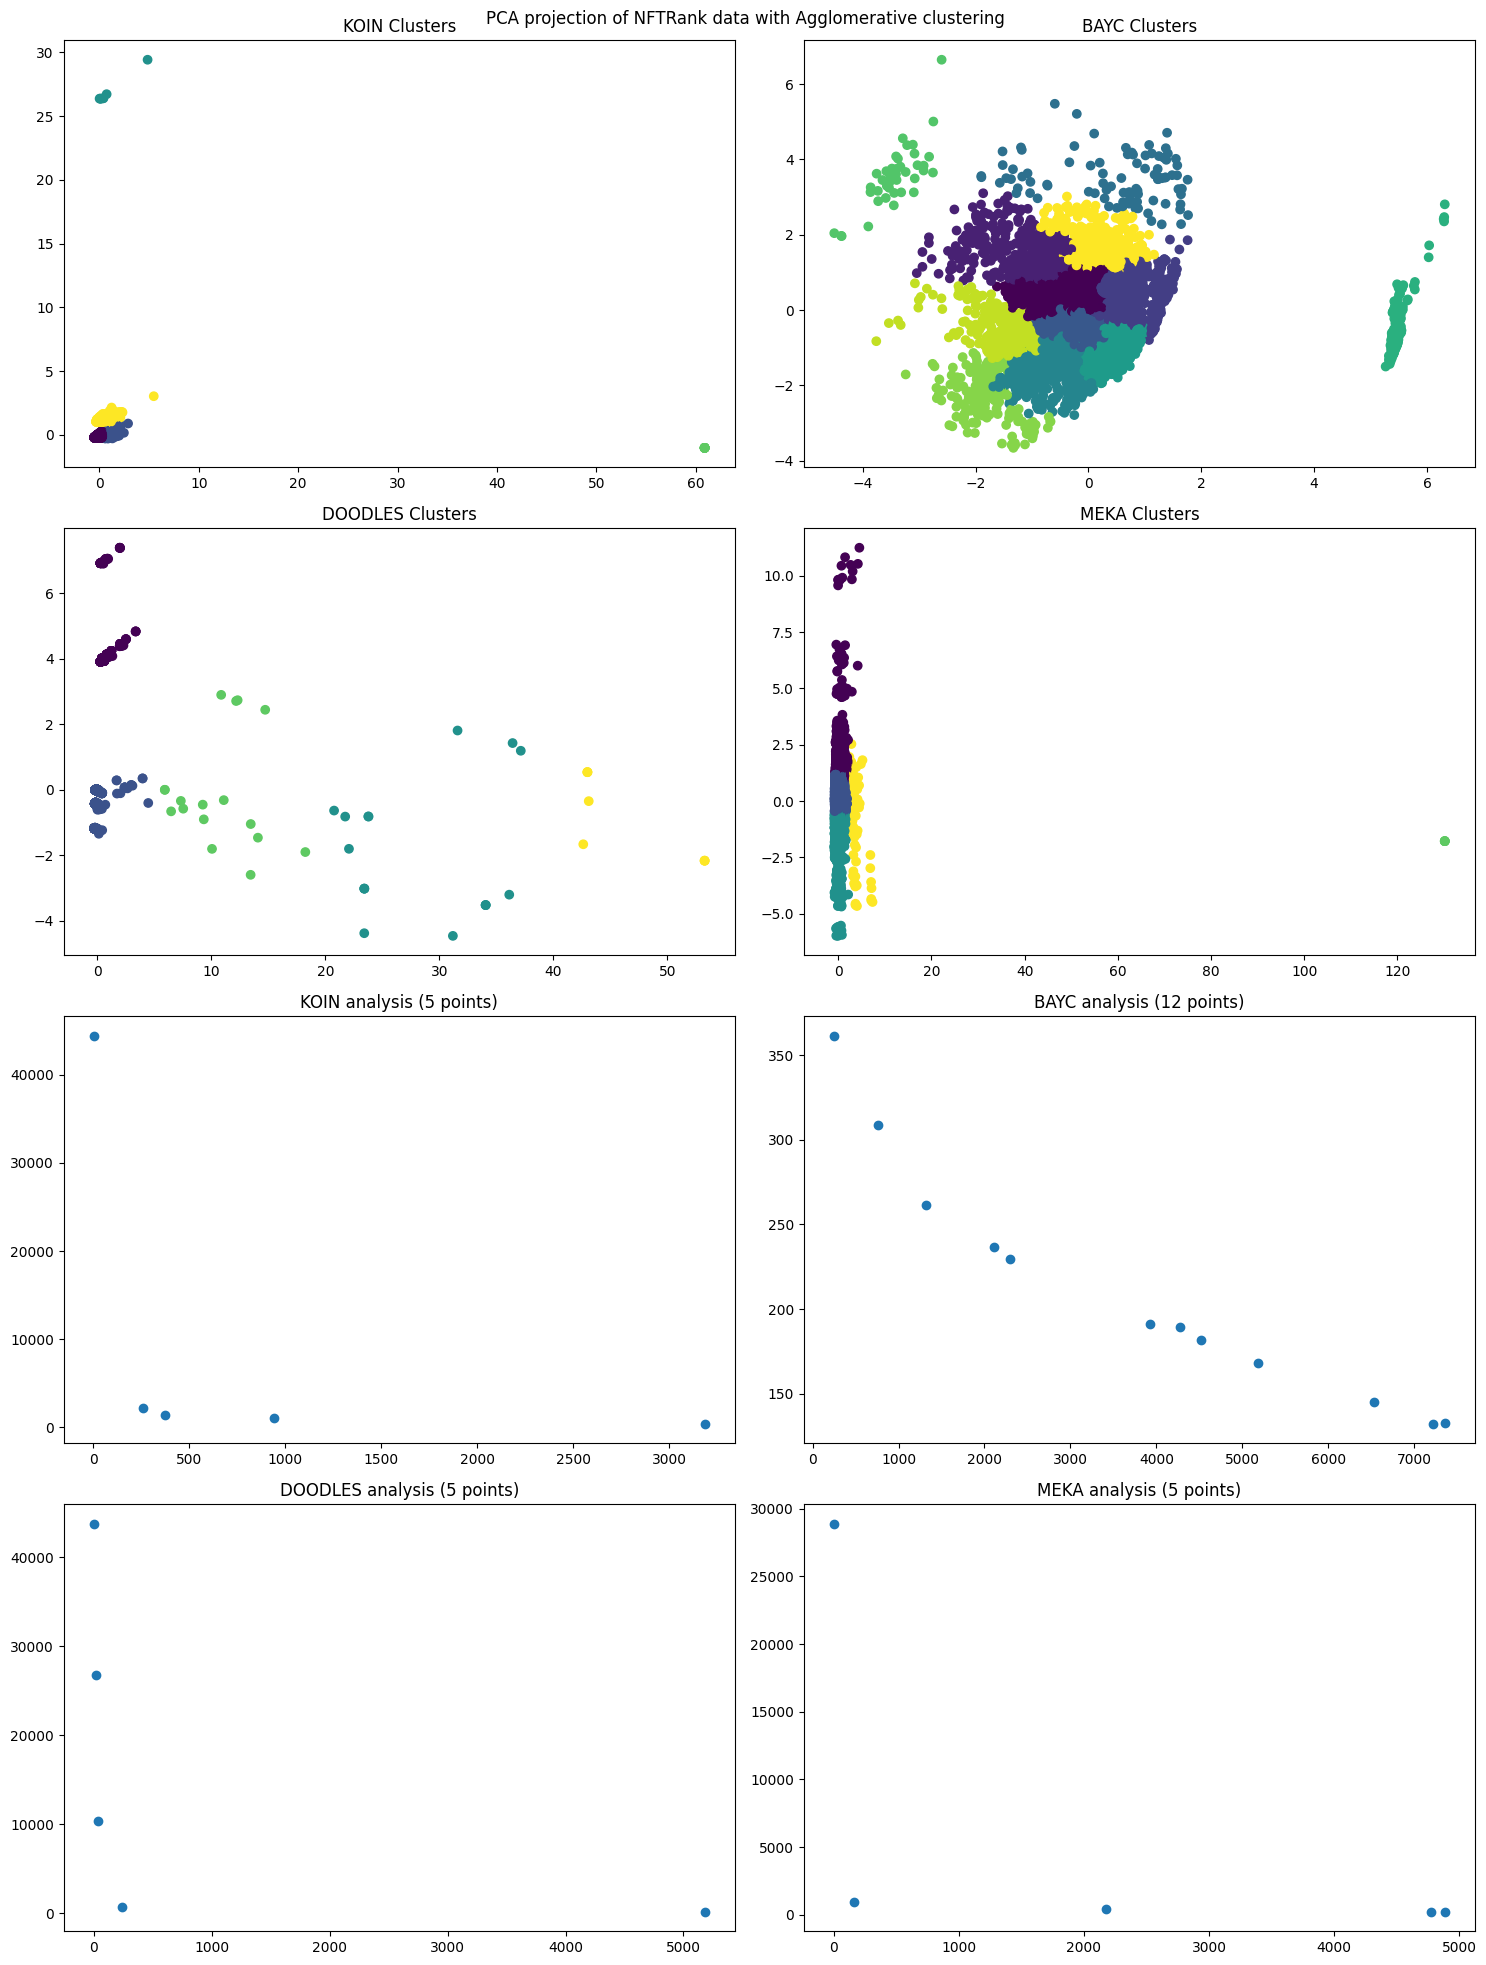

In [8]:
from sklearn.cluster import AgglomerativeClustering

def get_Agglomerative_labels_via_silhouette(embeddings):
    agglomerative_labels = []

    for embedding in embeddings:
        best_score = -1
        labels = 0

        for k in range(5, 15):
            agglomerative_model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')
            agglomerative_model.fit(embedding)
            score = silhouette_score(embedding, agglomerative_model.labels_)

            if score > best_score:
                best_score = score
                labels = agglomerative_model.labels_

        agglomerative_labels.append(labels)

    return agglomerative_labels

Agglomerative_clusters = get_Agglomerative_labels_via_silhouette(PCA_embeddings)
UMAP_Agglomerative_analysis = get_analysis(Agglomerative_clusters)

generate_PCA_cluster_plots_and_analyze(PCA_embeddings, Agglomerative_clusters, UMAP_Agglomerative_analysis, "with Agglomerative clustering")

In [9]:
def print_clusters(analysis):
    for i in range(0, len(analysis)):
        print("Cluster {}".format(analysis[i]['cluster_#']))
        for t in analysis[i]['top_five']:
            print("\t Rank: {}\t TokenId: {}".format(t[0], t[1]))

data_to_analyze = 2

In [12]:
print_clusters(PCA_DBSCAN_analysis[data_to_analyze]['analysis'])

Cluster 0
	 Rank: 1	 TokenId: 9659
	 Rank: 2	 TokenId: 7573
	 Rank: 3	 TokenId: 2912
	 Rank: 4	 TokenId: 2560
	 Rank: 5	 TokenId: 9243
Cluster 1
	 Rank: 49	 TokenId: 4262
	 Rank: 50	 TokenId: 3344
	 Rank: 51	 TokenId: 5967
	 Rank: 52	 TokenId: 9391
	 Rank: 53	 TokenId: 917
Cluster 2
	 Rank: 55	 TokenId: 75
	 Rank: 56	 TokenId: 2863
	 Rank: 57	 TokenId: 5212
	 Rank: 58	 TokenId: 2401
	 Rank: 66	 TokenId: 6936
Cluster 3
	 Rank: 77	 TokenId: 5962
	 Rank: 78	 TokenId: 4194
	 Rank: 79	 TokenId: 9533
	 Rank: 80	 TokenId: 9032
	 Rank: 81	 TokenId: 6522
Cluster 4
	 Rank: 86	 TokenId: 1085
	 Rank: 87	 TokenId: 6019
	 Rank: 88	 TokenId: 363
	 Rank: 89	 TokenId: 3526
	 Rank: 90	 TokenId: 5188
Cluster 5
	 Rank: 109	 TokenId: 3922
	 Rank: 110	 TokenId: 9495
	 Rank: 111	 TokenId: 4447
	 Rank: 125	 TokenId: 4882
	 Rank: 127	 TokenId: 1987
Cluster 6
	 Rank: 124	 TokenId: 9665
	 Rank: 154	 TokenId: 3903
	 Rank: 155	 TokenId: 7172
	 Rank: 159	 TokenId: 4788
	 Rank: 160	 TokenId: 3227
Cluster 7
	 Rank: 1